# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).



# ideas if these fial:
### drop param counts
### change lr
### keep trying random restarts.



# say in report

an issue faced was initialization. the weights were intiialized to values that made the arm swing round and round at max radius so it never hit the blal it seemed. after i changed that, it seemed fine! hmm... can sya in report.

to say in report: state preprocessing, action reducing to like smalelr amts.
small replay bufer??
experience more, update less but in one chunk.
simple architecrture cuz i think simple prob.

how did we discourage flailing?

ok we adapted this from one of the codes (bipedal). changed noise to normal and not ou. cuz ou keeps giving positive, not negative. bad. and also we dampened the actions and the noise. a lot. 

clip actions so it forcefully don't flail

move rewards to -0.05 to 0.05 instead of 0 to 0.1??

oh by measuring the distance and using that as reward? we turn a sparse problem into a non sparse one. more feedback, easier learn.


# info we've gotten
action has 4 dims. first 2 correspond to first joint (nearer to the "shoulder"), next 2 correspond to sedcond joint "elbow".
1 and 3 correspond to movement in vertical-ish axis. 2 and 4 for horizontal-ish.
seems that all can be clipped to 0.3 with no real harm.
episode has 1000 time steps. so ur agent has to be inside for 300 of the timesteps.

state 13 and 15 are the position of the arm horizontally. 14 is vertical.
26 and 27 (post processing) are position of ball. horizontally.

at its highest possible speed, the ball moves about 0.5 units per frame in total distance.

first 3 elements of state correspond to elbow position.



# eh we don't need parallelenv. delete. rename pong_utils.py too.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import pong_utils
import matplotlib
import matplotlib.pyplot as plt
import torch.optim as optim
import math
import torch
from ddpg_agent import Agent
from collections import deque
%matplotlib inline

import pdb
d = pdb.set_trace


Using this device: cuda:0


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='D:/Documents/GitHub/drlnd3/deep-reinforcement-learning/p2_continuous-control/Reacher_Windows_x86_64/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:

agent = Agent(state_size=29, action_size=4, random_seed=1779661)

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [5]:
'''
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
'''

"\n# reset the environment\nenv_info = env.reset(train_mode=True)[brain_name]\n\n# number of agents\nnum_agents = len(env_info.agents)\nprint('Number of agents:', num_agents)\n\n# size of each action\naction_size = brain.vector_action_space_size\nprint('Size of each action:', action_size)\n\n# examine the state space \nstates = env_info.vector_observations\nstate_size = states.shape[1]\nprint('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))\nprint('The state for the first agent looks like:', states[0])\n"

### 3. Take Random Actions in the Environment


# keep this code. might be useful later for simulating the weights directly. rmb u got 2 weights to load. also rmb set train mode to false

In [6]:
def preprocess_state(state):
    state = np.delete(state, 31, 1)
    state = np.delete(state, 30, 1)
    state = np.delete(state, 29, 1)
    state = np.delete(state, 27, 1)
    return state

In [7]:

def untraining_run():
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    state = preprocess_state(env_info.vector_observations)                  # get the current state (for each agent)
    agent.reset()
    score = 0                               # initialize the score (for each agent)
    while True:
        #action = np.random.randn(1, 4) # select an action (for each agent)
        action = agent.act(state)
        #action = np.array([0.15, 0.15, 0.15, 0.15])
        np.set_printoptions(precision=2, suppress=True)
        print('\r', state[0][1:4], state[0][26:28], end='')
        
        action = np.clip(action, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(action)[brain_name]           # send all actions to tne environment
        env_info = env.step(np.zeros(4))[brain_name]           # send all actions to tne environment
        env_info = env.step(np.zeros(4))[brain_name]           # send all actions to tne environment
        next_state = preprocess_state(env_info.vector_observations)         # get next state (for each agent)
        reward = env_info.rewards[0]                         # get reward (for each agent)
        done = env_info.local_done                        # see if episode finished
        
        
        
        
        state = next_state                               # roll over states to next time step
        score += reward                                   # update the score (for each agent)
        if np.any(done):                                  # exit loop if episode finished
            break
    print('\n', score)

#untraining_run()


When finished, you can close the environment.

In [8]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

d:\documents\github\drlnd3\env\lib\site-packages\torch\nn\functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 25	Average Score: 0.28959999	Score: 1.35
Episode 50	Average Score: 0.50959999	Score: 0.88
Episode 75	Average Score: 0.60613332	Score: 0.87
Episode 100	Average Score: 0.65989999	Score: 0.36
Episode 125	Average Score: 0.74319998	Score: 0.37
Episode 150	Average Score: 0.71369998	Score: 0.20
Episode 175	Average Score: 0.66039999	Score: 0.27
Episode 200	Average Score: 0.66479999	Score: 2.47
Episode 225	Average Score: 0.69639998	Score: 0.59
Episode 250	Average Score: 0.84209998	Score: 0.25
Episode 275	Average Score: 0.91699998	Score: 0.67
Episode 300	Average Score: 0.84859998	Score: 1.10
Episode 325	Average Score: 0.78199998	Score: 1.49
Episode 350	Average Score: 0.65769999	Score: 1.69
Episode 375	Average Score: 0.57349999	Score: 0.57
Episode 400	Average Score: 0.56399999	Score: 1.65
Episode 425	Average Score: 0.54279999	Score: 0.19
Episode 450	Average Score: 0.49019999	Score: 0.28
Episode 475	Average Score: 0.54549999	Score: 1.04
Episode 500	Average Score: 0.58589999	Score: 0.08
Epi

Episode 4050	Average Score: 5.46679988	Score: 5.627
Episode 4075	Average Score: 6.24759986	Score: 3.617
Episode 4100	Average Score: 6.85839985	Score: 8.084
Episode 4125	Average Score: 7.30199984	Score: 4.652
Episode 4150	Average Score: 7.40639983	Score: 5.990
Episode 4175	Average Score: 7.25129984	Score: 3.222
Episode 4200	Average Score: 7.83899983	Score: 9.103
Episode 4225	Average Score: 7.98179982	Score: 10.36
Episode 4250	Average Score: 8.36879981	Score: 12.98
Episode 4275	Average Score: 8.72419980	Score: 8.367
Episode 4300	Average Score: 8.55809981	Score: 8.842
Episode 4325	Average Score: 8.50099981	Score: 12.68
Episode 4350	Average Score: 8.51349981	Score: 10.80
Episode 4375	Average Score: 8.76219980	Score: 8.271
Episode 4400	Average Score: 8.95289980	Score: 11.40
Episode 4425	Average Score: 8.66039981	Score: 13.00
Episode 4450	Average Score: 9.22829979	Score: 7.798
Episode 4475	Average Score: 8.91619980	Score: 12.15
Episode 4500	Average Score: 8.99389980	Score: 12.40
Episode 4525

Episode 7925	Average Score: 16.35699963	Score: 16.96
Episode 7950	Average Score: 16.06129964	Score: 21.60
Episode 7975	Average Score: 16.11799964	Score: 3.742
Episode 8000	Average Score: 15.79809965	Score: 15.02
Episode 8025	Average Score: 16.50269963	Score: 22.39
Episode 8050	Average Score: 16.38779963	Score: 14.46
Episode 8075	Average Score: 16.65259963	Score: 20.06
Episode 8100	Average Score: 15.92799964	Score: 12.26
Episode 8125	Average Score: 15.80889965	Score: 24.60
Episode 8150	Average Score: 15.50469965	Score: 6.638
Episode 8175	Average Score: 15.52629965	Score: 13.66
Episode 8200	Average Score: 15.65329965	Score: 18.92
Episode 8225	Average Score: 14.95999967	Score: 38.69
Episode 8250	Average Score: 14.56209967	Score: 9.266
Episode 8275	Average Score: 13.64309970	Score: 11.65
Episode 8300	Average Score: 14.55889967	Score: 13.05
Episode 8325	Average Score: 14.73219967	Score: 14.19
Episode 8350	Average Score: 14.94689967	Score: 24.94
Episode 8375	Average Score: 16.00449964	Score:

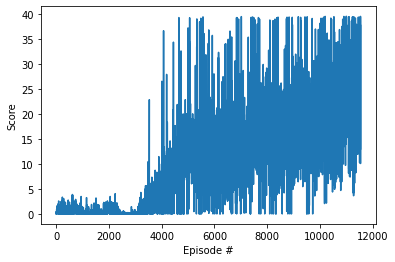

In [9]:
def ddpg():
    scores_deque = deque(maxlen=100)
    scores = []
    i_episode = 0
    while True:
        i_episode += 1
        episode_step = 0
        env_info = env.reset(train_mode=i_episode%400!=0)[brain_name]     # reset the environment; visualize every 100th episode
        state = preprocess_state(env_info.vector_observations)                  # get the current state (for each agent)
        agent.reset()
        score = 0
        while True:
            episode_step += 1
            action = agent.act(state)
            env_info = env.step(action)[brain_name]           # send all actions to tne environment
            next_state = preprocess_state(env_info.vector_observations)         # get next state (for each agent)
            reward = env_info.rewards[0]                         # get reward (for each agent)
            done = env_info.local_done[0]                        # see if episode finished
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.8f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), score), end="")
        if i_episode % 25 == 0:
            torch.save(agent.actor_local.state_dict(), f'checkpoint_actor_{i_episode}.pth')
            torch.save(agent.critic_local.state_dict(), f'checkpoint_critic_{i_episode}.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if sum(scores_deque) / len(scores_deque) >= 30:
            break
    return scores

scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [11]:
len(scores)
rolling avg

11541

In [ ]:
torch.save(agent.actor_local.state_dict(), f'checkpoint_actor_final.pth')
torch.save(agent.critic_local.state_dict(), f'checkpoint_critic_final.pth')

In [10]:
# save your policy!
#torch.save(policy, 'PPO.policy')

# load policy if needed
# policy = torch.load('PPO.policy')
